# Storing and displaying images

This notebook shows how to use NV-Ingest's extract and store tasks to extract images, charts, and tables from a multimodal pdf, store them in a Minio object store, and display them

To start we'll need to make sure we have the minio python client installed

In [ ]:
pip install -qU minio

Then, we'll use NV-Ingest to parse an example pdf that contains tables, charts, and images. We'll need to make sure to have the nv-ingest microservice up and running at localhost:7670 along with the supporting NIMs. To do this, follow the nv-ingest [quickstart guide](https://github.com/NVIDIA/nv-ingest?tab=readme-ov-file#quickstart). We'll also need to have the minio service up and [running](https://github.com/NVIDIA/nv-ingest/blob/main/docs/deployment.md#launch-nv-ingest-micro-services). Once the microservices are ready we can create a job with the nv-ingest python client

In [1]:
from nv_ingest_client.client import NvIngestClient
from nv_ingest_client.message_clients.rest.rest_client import RestClient
from nv_ingest_client.primitives import JobSpec
from nv_ingest_client.primitives.tasks import ExtractTask
from nv_ingest_client.primitives.tasks import StoreTask


from nv_ingest_client.util.file_processing.extract import extract_file_content
import logging, time

logger = logging.getLogger("nv_ingest_client")

file_name = "../data/multimodal_test.pdf"
file_content, file_type = extract_file_content(file_name)

job_spec = JobSpec(
    document_type=file_type,
    payload=file_content,
    source_id=file_name,
    source_name=file_name,
    extended_options={
        "tracing_options": {
            "trace": True,
            "ts_send": time.time_ns()
        }
    },
)

Then, we'll add an extract task and a store task with the relevant minio access key and secret. These both default to minioadmin

In [2]:
extract_task = ExtractTask(
    document_type=file_type,
    extract_text=True,
    extract_images=True,
    extract_tables=True,
)

store_task = StoreTask(
    structured=True,
    images=True,
    store_method="minio",
    access_key="minioadmin", 
    secret_key="minioadmin",
)

job_spec.add_task(extract_task)
job_spec.add_task(store_task)

client = NvIngestClient(
  message_client_hostname="localhost",
  message_client_port=7670
)

job_id = client.add_job(job_spec)

client.submit_job(job_id, "morpheus_task_queue")

result = client.fetch_job_result(job_id, timeout=60)

In [3]:
result[0][0][0]

{'document_type': 'image',
 'metadata': {'content': 'iVBORw0KGgoAAAANSUhEUgAAAdQAAADZCAYAAACZzsEGAAA9qUlEQVR4nO3daXQTZ57H+29ply3Jm2yDN2y8YGwIZjPB7GEnhJAOJGlIoJNu0tOZc++Z7hd35pz7as69L+4sZ3pNp3uSmU536E5I6IQECPu+GQM2ZrcNNl7wvsqyrL3uC8bqEEIgICNg/p9zcoKlUtVTj0r66Xmq6nkUVVVVhBBCCPFANJEugBBCCPEkkEAVQgghwkACVQghhAgDCVQhvoGqqvh8Ph7VSwzupXxDywghHg4JVPHEUlWViooK3nnnHf7t3/6Nbdu24XK57um1PT09/PrXvyYYDH7n7Z4/f55AIPCdX/dddHZ28vbbb99SvmAwyLVr1+jv7w8t8+tf//qe1ufxeHjvvffwer3DUl4Ah8PBtWvXhm39QkSaBKp4Yp0/f56dO3cyf/581q5dS3t7O/v27Qu16oLBIH6//5bXqKqK3+9HVVUGBgZue/zrvunxP//5z3g8nlseG1rnN/mmcgw9/vVgHtpeMBi87cdBMBhkz549tLS0hJYdGBj4xjJ+dT8BdDodc+fORafTfWMZ77YvgUDgth8fXy//jRs32LNnz13XL8Tj6u6fHiEeUydPnmTBggXk5uaiKApr1qwJdYFeunSJXbt24XK5SElJ4eWXX2ZgYIBNmzYxODiI2WwOhWJfXx8ffvgh/f39WCwW/H4/b731Fh0dHWzcuBGfz0dcXBzr1q3j448/pq2tjXfeeYfc3FxKSkr45JNPcLlcmEwmXnnlFRISEkJlPHXqFIcPH8blcjFmzBhWrlzJ5cuXOXHiBG63m+7ububMmcO8efPo6Ojg448/xuPxYDKZbmlN+v1+vvjiCy5cuEBnZyeZmZksWrSI7u5u3n77bTo7O8nOzmbt2rX4/X7+8pe/0NLSgqIorF27luTkZHbs2MG

Now, our images are stored in the `nv-ingest` bucket in minio. To browse the uploaded images we can go to the objects tab in the Minio console running at [http://localhost:9001](http://localhost:9001) or wherever the Minio console is running. We can also download and display the images using the Minio python client. First, we'll create a client and connect it to our Minio microservice

In [4]:
from minio import Minio

minio_client = Minio(
    "localhost:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)

Then, we'll get the name of the result folder which is just the url safe version of the name of the file that we performed the extraction on

In [5]:
from urllib.parse import quote

bucket = "nv-ingest"
results_folder = quote(file_name, safe="")

Next, we can use our bucket name and folder name to get all the objects that were extracted from our pdf

In [6]:
objects = minio_client.list_objects(bucket, prefix=results_folder+"/")

Finally, we can use the minio client to get the url for each image and then download them and display them in our notebook

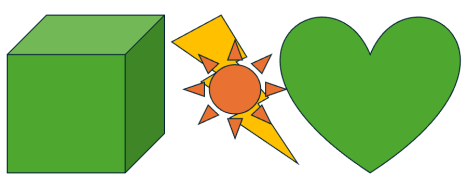

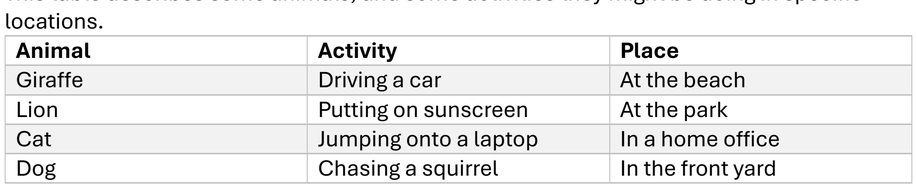

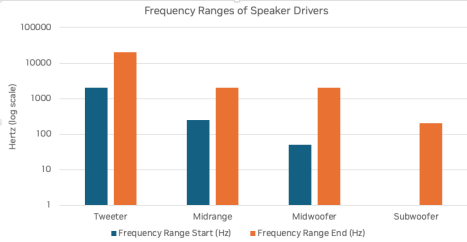

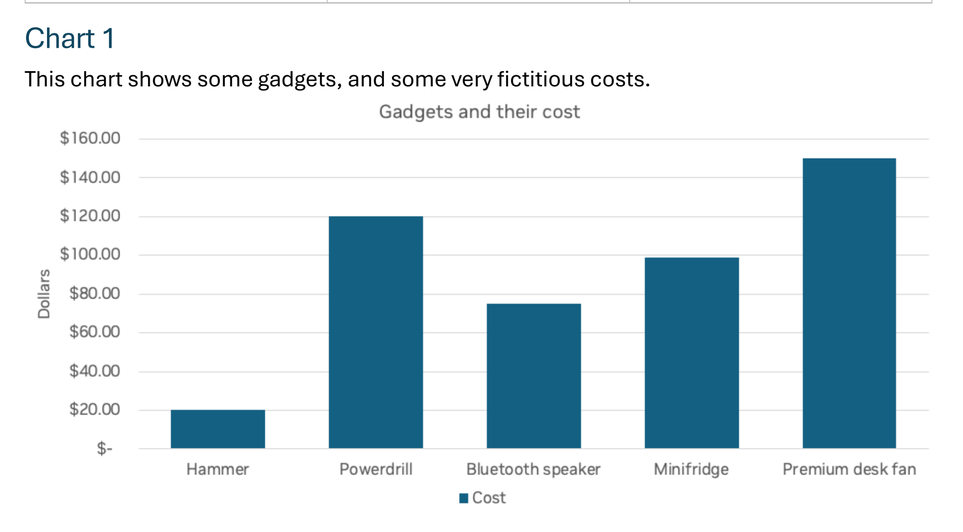

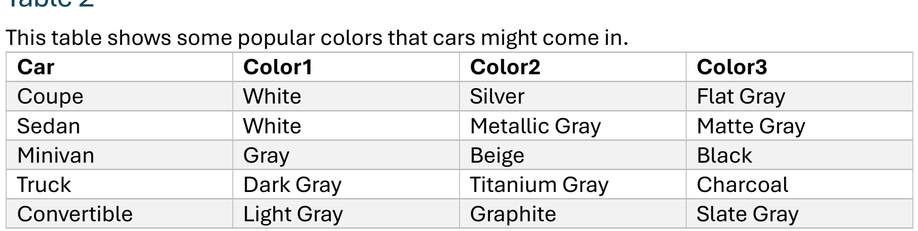

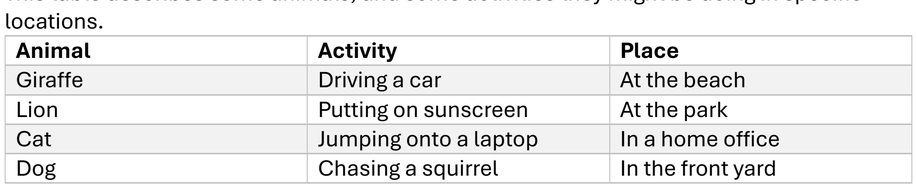

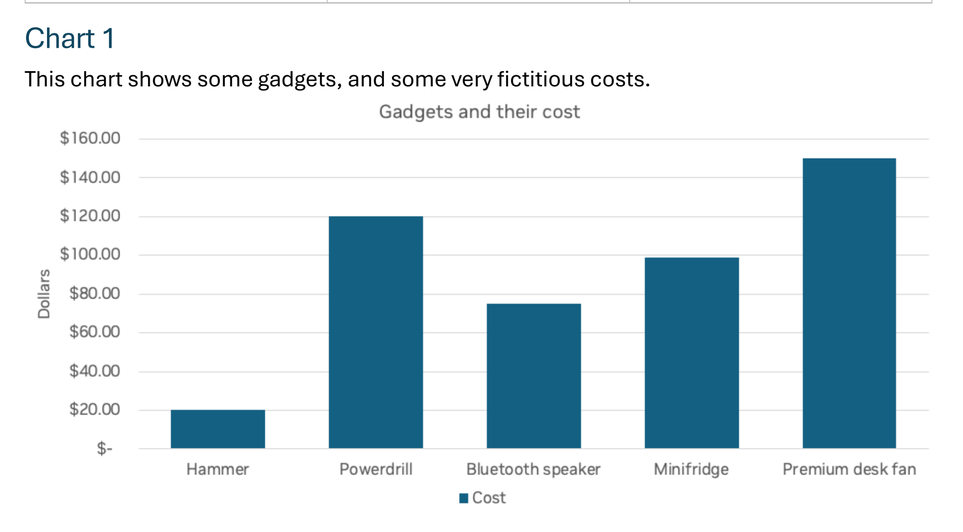

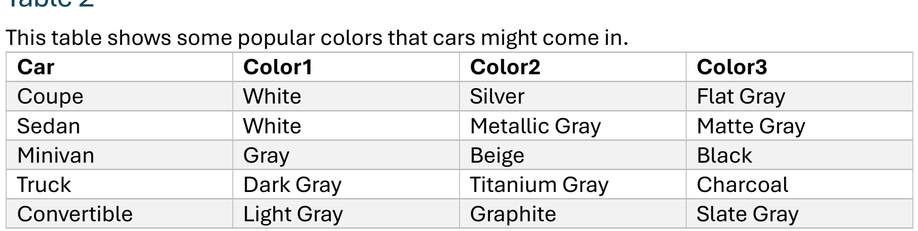

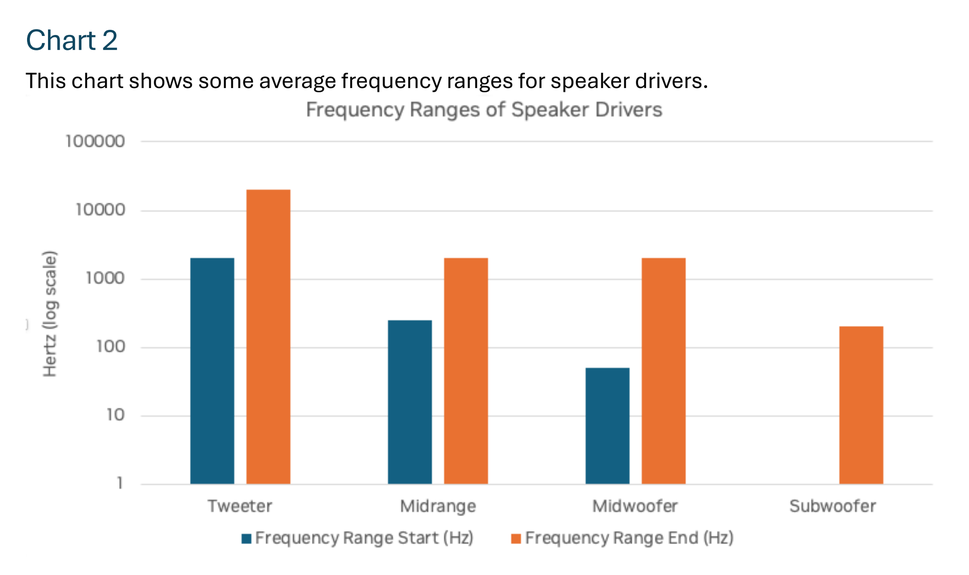

In [8]:
from PIL import Image
import requests
from io import BytesIO

for obj in objects:
    url = minio_client.presigned_get_object(bucket, obj.object_name)
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image.show() 